In [1]:
!pip3 install plotly-express
!pip3 install nbformat == 4.2.0
!pip install plotly

zsh:1: = not found


In [3]:
import pandas as pd 
import numpy as np 
import pickle
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import plotly 
import plotly_express as px 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots 
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
%config InlineBackend.figure_fromat = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 7,5

import warnings
warnings.filterwarnings('ignore')

In [5]:
#DataFrame from Kaggle COVID_19
data = pd.read_csv('covid_19_clean_complete.csv')

In [6]:
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [7]:
#Статистика по России
display(data[data['Country/Region'] == 'Russia'].tail())

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
47948,NaN,Russia,61.52401,105.318756,2020-07-23,793720,12873,579295,201552,Europe
48209,NaN,Russia,61.52401,105.318756,2020-07-24,799499,13026,587728,198745,Europe
48470,NaN,Russia,61.52401,105.318756,2020-07-25,805332,13172,596064,196096,Europe
48731,NaN,Russia,61.52401,105.318756,2020-07-26,811073,13249,599172,198652,Europe
48992,NaN,Russia,61.52401,105.318756,2020-07-27,816680,13334,602249,201097,Europe


In [8]:
data = data.dropna()

In [9]:
data.isnull().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
WHO Region        0
dtype: int64

<AxesSubplot:xlabel='Date'>

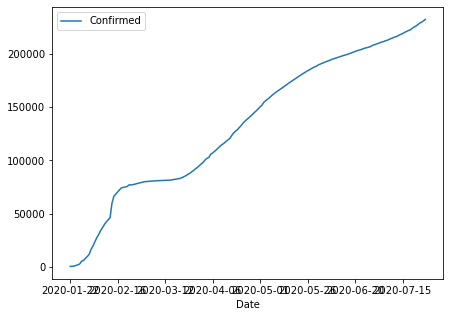

In [11]:
#Линейный график заболевших 
data[['Confirmed', 'Date']].groupby('Date').sum().plot()

<AxesSubplot:xlabel='Date'>

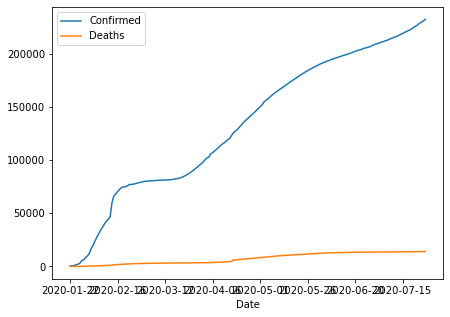

In [12]:
#Линейный график заболевших и умерших
data[['Confirmed', 'Deaths', 'Date']].groupby('Date').sum().plot()

Text(0, 0.5, 'Количество заболевших')

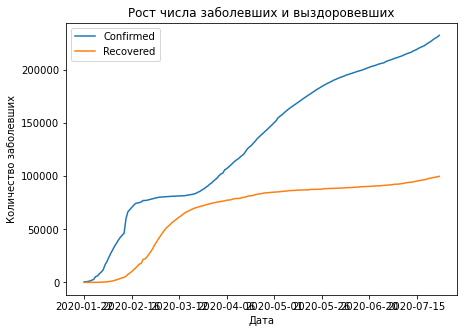

In [15]:
#Дополнительные настройки 
ax = data[['Confirmed', 'Recovered', 'Date']].groupby('Date').sum().plot(title = 'Рост числа заболевших и выздоровевших')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заболевших')

# Matplotlib

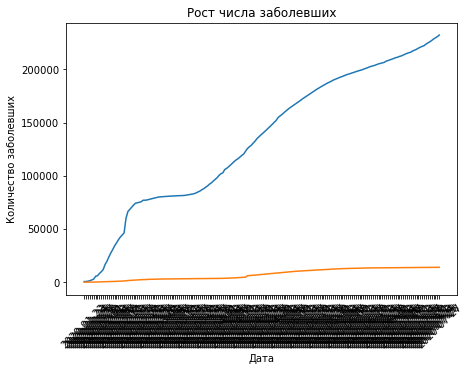

In [16]:
plt.plot(data[['Confirmed', 'Deaths', 'Date']].groupby('Date').sum())
plt.title('Рост числа заболевших')
plt.xlabel('Дата')
plt.ylabel('Количество заболевших')
plt.xticks(rotation = 45)
plt.show()

In [20]:
#Выделим 10 наиболее пострадавших стран по численности заболевших
df_top = data[data['Date'] == max(data.Date)]
df_top = df_top.groupby('Country/Region', as_index=False)['Confirmed'].sum()
df_top = df_top.nlargest(10, 'Confirmed')

In [22]:
#Выделим 10 наиболее пострадавших по дате
df_trend = data.groupby(['Date', 'Country/Region'], as_index=False)['Confirmed'].sum()
df_trend = df_trend.merge(df_top, on = 'Country/Region')
df_trend.rename(columns = {'Country/Region': 'Countries',
                           'Confirmed_x':'Cases',
                           'Date': 'Dates'
                          }, inplace = True)

In [23]:
px.line(df_trend,
       title = 'Рост числа выявленных случаев COVID-19',
       x = 'Dates',
       y = 'Cases',
       color = 'Countries')

In [24]:
#Логарифмирование 
df_trend['ln(Cases)'] = np.log(df_trend['Cases']+1)


In [25]:
px.line(df_trend,
       x = 'Dates',
       y = 'ln(Cases)',
       color = 'Countries',
       title = 'COVID-19 Рост числа заболевших в топ-10 стран')

<AxesSubplot:>

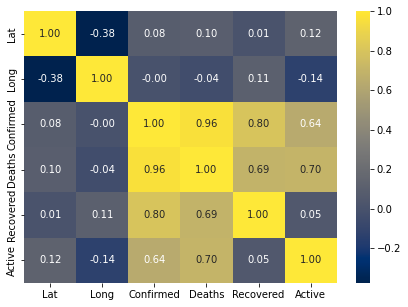

In [26]:
#HeatMap 
sns.heatmap(data.corr(), annot = True, fmt = '.2f', cmap = 'cividis')

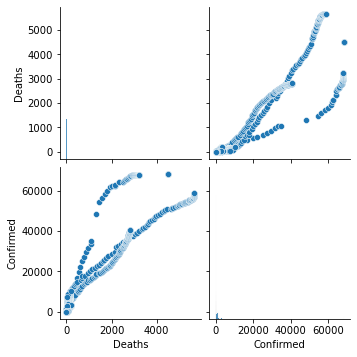

In [27]:
#Попарные двумерные распределения 
sns_plot = sns.pairplot(data[['Deaths', 'Confirmed']])
sns_plot.savefig('pairplot.png')

In [31]:
#Столбчатые диаграммы 
def add_daily_diffs(df):
    df.loc[0, 'Cases_daily'] = 0
    df.loc[0, 'Deaths_daily'] = 0
    for i in range (1, len(df)):
        df.loc[i, 'Cases_daily'] = df.loc[i, 'Confirmed'] - df.loc[i-1, 'Confirmed']
        df.loc[i, 'Deaths_daily'] = df.loc[i, 'Deaths'] - df.loc[i-1, 'Deaths']
    return df

df_world = data.groupby('Date', as_index = False)['Deaths', 'Confirmed'].sum()
df_world = add_daily_diffs(df_world)

fig = go.Figure(data = [
    go.Bar(name = 'Количество заболевших',
          marker = {'color': 'rgb(0,100,153)'},
          x = df_world.Date,
          y = df_world.Cases_daily),
    go.Bar(name = 'Количество смертей', x = df_world.Date, y = df_world.Deaths_daily)
])

#даты введения локдауна в Италии, Ухаи и Великобритании 
fig.update_layout(barmode = 'overlay', title = 'Статистика заболеваний COVID-19',
                 annotations = [dict(x = '2020 - 01 - 23', y=1797, text = 'Локдаун в Ухани',
                               showarrow = True, arrowhead = 1, ax = - 100, ay = - 200),
                               dict(x = '2020-03-09', y=1797, text = 'Локдаун в Италии',
                               showarrow = True, arrowhead = 1, ax = - 100, ay= - 200),
                               dict(x = '2020-03-23', y=19000, text = 'Лоудаун в UK',
                               showarrow = True, arrowhead = 1, ax=-100, ay=-200)])

In [35]:
#Столбчатая диаграмма 
df_mortality = data.query('(Date == "2020-07-17") & (Confirmed > 100)')
df_mortality['mortality'] = df_mortality['Deaths']/df_mortality['Confirmed']
df_mortality['mortality'] = df_mortality['mortality'].apply(lambda x: round(x,3))
df_mortality.sort_values('mortality', ascending = False, inplace = True)

df_mortality.drop_duplicates(subset = ['Country/Region'], keep = 'first', inplace = True)
fig = px.bar(df_mortality[:20].iloc[::-1],
            x='mortality',
            y='Country/Region',
            labels = {'mortality': 'Уровень смертности',
                     'Country_Region':'Страна'},
            title = f'Уровень смертности',
            text = 'mortality',
            height = 800,
            orientation = 'h')
fig.show()